In [22]:
%matplotlib inline
from collections import Counter
import numpy as np
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import pandas as pd

In [111]:
def construct_matrix(spec_donors=[],reject_donors=[],donor_sex=None,donor_age=[],spec_tissues=[],reject_tissues=[],
                       top_tissues=None,min_tissue_count=None):
    #     This function builds a numpy matrix and associated data arrays for the specified
    
    #     --Parameters--
    #     spec_donors: Array of donor ID strings to include. Leave blank for all donors.
    #     reject_donors: Array of donor IDs to remove. Leave blank to reject no donors.
    #     donor_sex: '1' for only males, '2' for only females, None (or blank) for all donors.
    #     donor_age: Array of age-decade strings to include, e.g. ['20','30','40']. Leave blank for all donors.
    #     spec_tissues: Array of tissue names to include. Leave blank for all tissues.
    #     reject_tissues: Array of tissue names to remove. Leave blank to reject no tissues.
    #     top_tissues: Number of most commonly sampled tissues to include. Leave blank to include all tissues.
    #     min_tissue_count: Minimum number of samples to include a tissue. Leave blank to include all tissues.

    #     Note: spec_donors and reject_donors are mutually exclusive.
    #     Note: spec_tissues and reject_tissues are mutually exclusive.
    #     Note: top_tissues and min_tissue_count are mutually exclusive.
    
    #     --Returns--
    #     multi_matrix: Numpy matrix of 10,000 rows, column for each included sample
    #     point_ID: Array of donor IDs for each column in multi_matrix
    #     point_sex: Array of donor sex for each column in multi_matrix
    #     point_age: Array of donor age for each column in multi_matrix
    #     point_tissue: Array of tissue type for each column in multi_matrix
    #     point_tissue_group: Array of tissue group (just first term of tissue type) for each column in multi_matrix

    # DONORS BY ID
    if not spec_donors:
        all_donors = open('../data/donors_list.txt')
        donor_list = [ID[0:-1] for ID in all_donors if ID[0:-1] not in reject_donors]
        all_donors.close()
    else:
        donor_list = spec_donors
    # dictionary of donor IDs, and an array that will be [sex,age]
    donor_dict = dict((ID,[]) for ID in donor_list)

    # DONORS BY AGE AND SEX
    donor_info = open('../data/donor_info.txt')
    for line in donor_info:
        # info is [ID,sex,age,death]
        info = line.split('\t')
        if info[0] in donor_list:
            # check sex
            if donor_sex and info[1] != donor_sex:
                del donor_dict[info[0]]
                continue
            else:
                donor_dict[info[0]].append(info[1])
            # check age    
            age = info[2].split('-')[0]
            if donor_age and age not in donor_age:
                del donor_dict[info[0]]
                continue
            else:
                donor_dict[info[0]].append(age)
    donor_info.close()

    # TISSUES BY TYPE AND SAMPLE COUNT
    tissues = Counter()
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata/donor_meta_'+ID+'.txt')
        for line in metafile:
            # look for tissue type listed in meta file
            tissue = line.split('\t')[1][0:-1]
            if spec_tissues and tissue in spec_tissues:
                tissues[tissue] = tissues.get(tissue,0) + 1
            elif not spec_tissues and tissue not in reject_tissues:
                tissues[tissue] = tissues.get(tissue,0) + 1
        metafile.close()
    if min_tissue_count:
        tissue_list = [key for key,value in tissues.iteritems() if value >= min_tissue_count]
    else:
        tissue_list = [key for key,value in tissues.most_common(top_tissues)]

    # CONSTRUCT MATRIX
    # initialize column (to be removed) and info types
    multi_matrix = np.zeros((10000,1))
    point_ID = []
    point_sex = []
    point_age = []
    point_tissue = []
    point_tissue_group = []
    # metadata on relevant points
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata/donor_meta_'+ID+'.txt')
        # column indices for relevant tissues
        columns = []
        column = 0
        for line in metafile:
            tissue = line.split('\t')[1][0:-1]      
            if tissue in tissue_list:
                columns.append(column)
                point_ID.append(ID)
                point_sex.append(donor_dict[ID][0])
                point_age.append(donor_dict[ID][1])
                point_tissue.append(tissue)
                point_tissue_group.append(tissue.split('-')[0])
            column = column + 1
        metafile.close()
        # get data
        donor_matrix = np.zeros((10000,len(columns)))
        row = 0
        donorfile = open('../data/donor_matrices_fixed/donor_'+ID+'.txt')
        for line in donorfile:
            # from file, take desired tissue columns and put in donor matrix
            values = [line.split('\t')[ind] for ind in columns]
            donor_matrix[row,:] = values
            row = row+1
        donorfile.close()
        # concatenate donor matrices
        multi_matrix = np.concatenate((multi_matrix,donor_matrix),axis=1)
    multi_matrix = np.delete(multi_matrix,0,1)
    
    print 'Matrix constructed with ' + str(multi_matrix.shape[1]) + ' samples!'
    return [multi_matrix, point_ID, point_sex, point_age, point_tissue, point_tissue_group]

In [112]:
def perform_pca(multi_matrix):
    #     This function transposes and performs PCA on given matrix
    
    #     --Parameters--
    #     multi_matrix: Should be created using construct_matrix function
    
    #     --Returns--
    #     data_pca: 2D Array
    
    pca = decomposition.PCA(n_components=2)
    data_pca = pca.fit_transform(multi_matrix.transpose())
    print 'PCA complete'
    return data_pca

def perform_mds(multi_matrix):
    #     This function transposes and performs MDS on given matrix
    
    #     --Parameters--
    #     multi_matrix: Should be created using construct_matrix function
    
    #     --Returns--
    #     data_mds: 2D Array
    
    mds = manifold.MDS(n_components=2)
    data_mds = mds.fit_transform(multi_matrix.transpose())
    print 'MDS complete'
    return data_mds

def perform_tsne(multi_matrix):
    #     This function transposes and performs tSNE on given matrix
    
    #     --Parameters--
    #     multi_matrix: Should be created using construct_matrix function
    
    #     --Returns--
    #     data_tsne: 2D Array
    
    tsne = manifold.TSNE(n_components=2)
    data_tsne = tsne.fit_transform(multi_matrix.transpose())
    print 'tSNE complete'
    return data_tsne

In [113]:
def construct_dataframe(data_array, point_ID, point_sex, point_age, point_tissue, point_tissue_group, output_name=None):
    #     This function constructs a pandas dataframe out of all data so far. It can also write the dataframe to file.
    
    #     --Parameters--
    #     data_array: Output from dimensionality reduction, e.g. data_tsne
    #     point_: Corresponding outputs from construct_matrix function
    #     output_name: Name of file to write dataframe. Append .csv suffix. Omit if no saving desired.
    
    #     Note: Make output_name memorable. It should include any info about dataframe, e.g. male_heart_PCA.csv
    
    #     --Returns--
    #     df: Pandas dataframe
    df = pd.DataFrame(data_array,columns=['DIM1','DIM2'])
    df['ID'] = point_ID
    df['sex'] = point_sex
    df['age'] = point_age
    df['tissue'] = point_tissue
    df['group'] = point_tissue_group
    # save to file
    if output_name:
        df.to_csv(output_name,sep='\t')
        print 'Dataframe saved as ' + output_name
    return df

In [114]:
def plot_data(dataframe=None,input_name=None,plot_spec_donors=None,plot_reject_donors=None,plot_sex=None,
              plot_age=None,plot_spec_tissues=None,plot_reject_tissues=None,colorby='tissue'):
    #     This function plots a dataframe. It returns nothing
    
    #     --Parameters--
    #     dataframe: Pandas dataframe as output by construct_dataframe. Leave blank if reading from file.
    #     input_name: File where Pandas dataframe located. Leave blank if reading from memory.
    #     plot_spec_donors: Array of donor IDs to be plotted. Leave blank to include all donors.
    #     plot_reject_donors: Array of donor IDs to be plotted. Leave blank to reject no donors.
    #     plot_sex: '1' to plot only males, '2' to plot only females. Leave blank to plot both sexes.
    #     plot_age: Array of age ranges to be plotted, e.g. ['20','30']. Leave blank to include all ages.
    #     plot_spec_tissues: Array of tissues to plot. Leave blank to plot all tissues.
    #     plot_reject_tissues: Array of tissues not to plot. Leave blank to reject no tissues.
    #     colorby: Color points according to 'tissues', 'sex', 'age', or 'group'. Leave blank to color by 'tissues'.
    
    #     Note: dataframe and input_name are mutually exclusive.
    #     Note: spec_donors and reject_donors are mutually exclusive.
    #     Note: spec_tissues and reject_tissues are mutually exclusive.
    
    if input_name:
        df = pd.read_csv(input_name,sep='\t')
    else:
        df = dataframe
    
    remove = []
    # if specific donors selected
    for ind,row in df.iterrows():
        if plot_spec_donors:
            if row['ID'] not in plot_spec_donors:
                remove.append(ind)
                continue
        elif plot_reject_donors:
            if row['ID'] in plot_reject_donors:
                remove.append(ind)
                continue
        
        if plot_sex:
            if row['sex'] != plot_sex:
                remove.append(ind)
                continue
        
        if plot_age:
            if row['age'] not in plot_age:
                remove.append(ind)
                continue
        
        if plot_spec_tissues:
            if row['tissue'] not in plot_spec_tissues:
                remove.append(ind)
                continue
        elif plot_reject_tissues:
            if row['tissue'] in plot_reject_tissues:
                remove.append(ind)
    
    df = df.drop(df.index[remove])
    
    labels = set(df[colorby])
    jet = plt.get_cmap('jet')
    colors = jet(np.linspace(0, 1, len(labels)))
    color = 0
    
    fig, ax = plt.subplots(figsize = (10,10))
    for i,group in df.groupby(colorby):
        group.plot(x='DIM1',y='DIM2',kind='scatter',label=i,color=colors[color],ax=ax)
        color = color + 1
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

In [131]:
[multi_matrix, point_ID, point_sex, point_age, point_tissue, point_tissue_group] = construct_matrix(
    spec_tissues=['Whole Blood'])
data_tsne = perform_tsne(multi_matrix)
df = construct_dataframe(data_tsne, point_ID, point_sex, point_age, point_tissue, point_tissue_group,
                         output_name='../csv_output_files/whole_blood_tsne.csv')

Matrix constructed with 393 samples!
tSNE complete
Dataframe saved as ../csv_output_files/whole_blood_tsne.csv


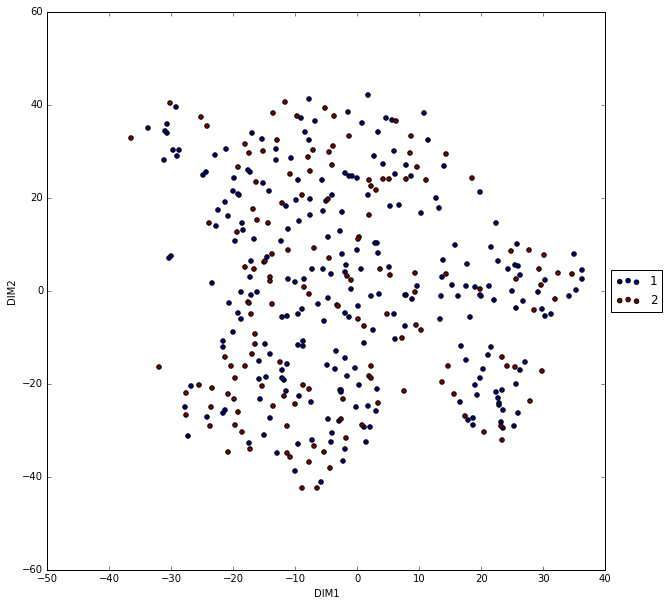

In [132]:
plot_data(input_name='../csv_output_files/whole_blood_tsne.csv',colorby='sex')